# MCMC samples from the true posterior for the CR model

Problem: Given an observed data set, generate MCMC samples from the posterior distribution.

Reason: This is needed in order to define a performance metric.

In [1]:
# Install dependencies
!pip install emcee corner --quiet

In [2]:
import numpy as np
import emcee
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import LSTM
from scipy.stats import norm
from scipy.integrate import solve_ivp, dblquad
import random

from bayesflow.networks import InvertibleNetwork
from bayesflow.amortizers import SingleModelAmortizer
from bayesflow.trainers import ParameterEstimationTrainer
from bayesflow.diagnostics import *
from bayesflow.error_metrics import *
from bayesflow.models import GenerativeModel

2022-11-15 09:49:55.515355: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-15 09:49:55.515369: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
# ODE model for conversion reaction 
def prior(batch_size):
    """
    Samples from the prior 'batch_size' times.
    ----------
    Output:
    theta : np.ndarray of shape (batch_size, theta_dim) 
    """    
    # Prior range for log-parameters: k_1, k_2 ~ N(-0.75, 0.25²) iid.
    p_samples = np.random.normal(-0.75, 0.25, size=(batch_size, 2))
    return p_samples.astype(np.float32)
   
def conversion_reaction(t, x, theta):
    theta = 10**theta
    return np.array([-theta[0]*x[0]+theta[1]*x[1], theta[0]*x[0]-theta[1]*x[1]])

x0 = [1,0]   # initial condition       
sigma = 0.015   # noise standard deviation
n_obs = 3
time_points = np.linspace(0, 10, n_obs)
missing_max = 2

def batch_simulator_augment01(prior_samples, n_obs):
    """
    Simulate multiple conversion model datasets with missing values and augmentation by zeros/ones
    """   
    n_sim = prior_samples.shape[0]   # batch size 
    sim_data = np.ones((n_sim, n_obs, 2), dtype=np.float32)   # 1 batch consisting of n_sim datasets, each with n_obs observations
    n_missing = np.random.randint(0, missing_max+1, size=n_sim)
    
    for m in range(n_sim):
        theta = 10**prior_samples[m]
        s = theta[0] + theta[1]
        b = theta[0]/s
        state_2 = lambda t: b - b * np.exp(-s*t)
        sol = state_2(time_points)
        sim_data[m, :, 0] = sol + np.random.normal(0, sigma, size = n_obs)   # observable: y = x_2 + N(0,sigma²) 
        
        # artificially induce missing data
        missing_indices = random.sample(range(n_obs), n_missing[m])
        sim_data[m][missing_indices] = np.array([-1.0, 0.0])  
        
    return sim_data

We build an amortized parameter estimation network.

In [5]:
bf_meta = {
    'n_coupling_layers': 5,
    's_args': {
        'units': [64, 64, 64],
        'activation': 'elu',
        'initializer': 'glorot_uniform',
    },
    't_args': {
        'units': [64, 64, 64],
        'activation': 'elu',
        'initializer': 'glorot_uniform',
    },
    'n_params': 2
}

## MCMC samples

Generate representative samples from each posterior via MCMC. This is time-intensive. If this has been run already once and results have been stored, once can directly proceed by loading them in the "Load" section.

In [ ]:
n_params = 100   # you should change it to 500
true_params = prior(n_params) 
x_augment01 = batch_simulator_augment01(true_params, n_obs).astype(np.float32)

In [7]:
%%time
# "True" means via MCMC sampling
mcmc_means = np.empty((n_params, 2))

from multiprocessing import Pool

from tqdm import tqdm

def do_sth(i):
    present_timepoints = time_points[x_augment01[i,:,1]==1]
    present_data = x_augment01[i, x_augment01[i,:,1]==1, 0]
    
    def log_prior(x,y):   
        # Evaluates log-prior probability p(theta) according to k_1, k_2 ~ N(-0.75, 0.25²) iid.
        return norm.logpdf(x,-0.75,0.25) + norm.logpdf(y,-0.75,0.25)

    def log_likelihood(x,y):   
        # Calculates log-likelihood p(x_{1:N} | theta) by ignoring the missing data
        x = 10**x
        y = 10**y
        s = x + y
        b = x/s
        state_2 = lambda t: b - b * np.exp(-s*t)
        sol = state_2(present_timepoints)
        residual = (present_data - sol)/sigma
        nllh = np.sum(np.log(2*np.pi*sigma**2)+residual**2)/2
        return - nllh

    def log_posterior(x,y):   
        # Evaluates the unnormalized log-posterior probability p(theta | x_{1:N}) according to Bayes' formula
        return log_likelihood(x,y) + log_prior(x,y)

    def log_posterior_v(x: np.ndarray):
        """Log-posterior with a single vector-valued argument."""
        x, y = x
        return log_posterior(x, y)

    def sample(n_sample=10000, n_walker=10):
        """Perform sampling using emcee."""
        n_dim = 2
        p0 = np.random.randn(n_walker, n_dim)
        #with multiprocessing.Pool() as pool:
        sampler = emcee.EnsembleSampler(n_walker, n_dim, log_posterior_v)
        sampler.run_mcmc(p0, n_sample)    
        samples = sampler.get_chain(flat=True)
        return samples

    # Sample
    samples = sample(n_sample=10000)
    
    # Posterior mean
    return (i, np.array([np.mean(samples[:, 0]), np.mean(samples[:, 1])]))

with Pool() as pool:
    results = list(tqdm(pool.imap_unordered(do_sth, range(n_params)), total=n_params))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [11:18<00:00,  6.79s/it]

CPU times: user 696 ms, sys: 130 ms, total: 826 ms
Wall time: 11min 18s


In [8]:
results = sorted(results, key=lambda x: x[0])
mcmc_means = np.array([r for _, r in results])

In [9]:
mcmc_means[:10,:]

array([[-0.82139527, -0.71616316],
       [-0.7520882 , -0.7482915 ],
       [-0.86669488, -0.82418335],
       [-0.74697763, -0.76043405],
       [-0.65187838, -0.63800977],
       [-0.70400395, -0.80088158],
       [-0.47037992, -0.88570748],
       [-0.77897435, -0.74421253],
       [-0.70381123, -0.47948836],
       [-0.38858254, -0.73447043]])

## Save results

In [10]:
np.save("true_params.npy", true_params)
np.save("mcmc_means.npy", mcmc_means)
np.save("x_augment01.npy", x_augment01)

## Load results

In [11]:
true_params = np.load("true_params.npy")
mcmc_means = np.load("mcmc_means.npy")
x_augment01 = np.load("x_augment01.npy")

## Sample Augment 0/1 from BayesFlow

In [12]:
%%time

# Augment by 0/1
summary_net = LSTM(8)
inference_net = InvertibleNetwork(bf_meta)
amortizer = SingleModelAmortizer(inference_net, summary_net)
trainer = ParameterEstimationTrainer(network=amortizer, checkpoint_path='./CR3__augment01__5ACB__64_64_64__LSTM8__ckpts', skip_checks=True)

# BayesFlow samples from the learned posterior
param_samples_augment01 = amortizer.sample(x_augment01, n_samples=1000)
v_augment01 = bootstrap_metrics(np.swapaxes(param_samples_augment01, 0, 1), mcmc_means)
a1 = display_metrics(v_augment01)

2022-11-15 10:01:15.397843: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-11-15 10:01:15.397863: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-11-15 10:01:15.397877: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (yoga): /proc/driver/nvidia/version does not exist
2022-11-15 10:01:15.398101: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


TRAINER INITIALIZATION: No generative model provided. Only offline learning mode is available!
Networks loaded from ./CR3__augment01__5ACB__64_64_64__LSTM8__ckpts/ckpt-300
NRMSE(k_1): 0.009 ± 0.001
NRMSE(k_2): 0.010 ± 0.002
R²(k_1): 0.998 ± 0.000
R²(k_2): 0.996 ± 0.001
CPU times: user 4.3 s, sys: 279 ms, total: 4.58 s
Wall time: 1.76 s


In [13]:
bayesflow_means = np.mean(param_samples_augment01, axis=1)
bayesflow_means[:10,:]

array([[-0.8169264 , -0.70605034],
       [-0.7157411 , -0.74181324],
       [-0.87111837, -0.8316483 ],
       [-0.7495153 , -0.7635713 ],
       [-0.6537908 , -0.6394731 ],
       [-0.7059356 , -0.803759  ],
       [-0.46461833, -0.8729723 ],
       [-0.77420354, -0.739781  ],
       [-0.703153  , -0.47945336],
       [-0.39377686, -0.73791957]], dtype=float32)

## Sample Insert c from BayesFlow

In [20]:
%%time

# Insert -1
summary_net = LSTM(8)
inference_net = InvertibleNetwork(bf_meta)
amortizer = SingleModelAmortizer(inference_net, summary_net)
trainer = ParameterEstimationTrainer(network=amortizer, checkpoint_path='./CR3_insert_n1_5ACB_64_64_64_LSTM8_ckpts', skip_checks=True)
                                                                            
# BayesFlow samples from the learned posterior
x_insert = np.ones((n_params, n_obs, 1), dtype=np.float32)
for m in range(n_params):
    x_insert[m, :, 0] = x_augment01[m, :, 0]
    
param_samples_insert = amortizer.sample(x_insert, n_samples=1000)
v_insert = bootstrap_metrics(np.swapaxes(param_samples_insert, 0, 1), mcmc_means)
a2 = display_metrics(v_insert)

TRAINER INITIALIZATION: No generative model provided. Only offline learning mode is available!
Initializing networks from scratch.
NRMSE(k_1): 0.768 ± 0.049
NRMSE(k_2): 0.690 ± 0.081
R²(k_1): -11.786 ± 1.621
R²(k_2): -14.306 ± 2.543
CPU times: user 3.31 s, sys: 29.6 ms, total: 3.34 s
Wall time: 1.03 s


## Sample Time labels from BayesFlow

In [15]:
%%time

# Time labels
summary_net = LSTM(8)
inference_net = InvertibleNetwork(bf_meta)
amortizer = SingleModelAmortizer(inference_net, summary_net)
trainer = ParameterEstimationTrainer(network=amortizer, checkpoint_path='./CR3_timepoints_5ACB_64_64_64_LSTM8_ckpts', skip_checks=True)
# BayesFlow samples from the learned posterior
param_samples_timepoints = np.empty((n_params, 1000, 2), dtype=np.float32)
for m in range(n_params):
    x = x_augment01[m, :, 1]
    present_indices = np.where(x == 1.)[0]
    x_timepoints = np.empty((1, len(present_indices), 2), dtype=np.float32)
    x_timepoints[0, :, 0] = x_augment01[m, present_indices, 0]
    x_timepoints[0, :, 1] = time_points[present_indices]
    param_samples_timepoints[m] = amortizer.sample(x_timepoints, n_samples=1000)
v_timepoints = bootstrap_metrics(np.swapaxes(param_samples_timepoints, 0, 1), mcmc_means)
a3 = display_metrics(v_timepoints)

TRAINER INITIALIZATION: No generative model provided. Only offline learning mode is available!
Networks loaded from ./CR3__timepoints__5ACB__64_64_64__LSTM8__ckpts/ckpt-300
NRMSE(k_1): 0.010 ± 0.001
NRMSE(k_2): 0.012 ± 0.002
R²(k_1): 0.998 ± 0.001
R²(k_2): 0.995 ± 0.002
CPU times: user 6.46 s, sys: 357 ms, total: 6.82 s
Wall time: 4.19 s


## Visualize

In [16]:
def true_vs_estimated(theta_true, theta_est, param_names, figsize=(8, 4), show=True, filename=None, font_size=12):
    """ Plots a scatter plot with abline of the estimated posterior means vs true values. """

    # Plot settings
    plt.rcParams['font.size'] = font_size

    # Determine n_subplots dynamically
    n_row = int(np.ceil(len(param_names) / 6))
    n_col = int(np.ceil(len(param_names) / n_row))

    # Initialize figure
    f, axarr = plt.subplots(n_row, n_col, figsize=figsize)
    if n_row > 1:
        axarr = axarr.flat
        
    # --- Plot true vs estimated posterior means on a single row --- #
    for j in range(len(param_names)):
        
        # Plot analytic vs estimated
        axarr[j].scatter(theta_est[:, j], theta_true[:, j], color='black', alpha=0.4)
        
        # get axis limits and set equal x and y limits
        lower_lim = min(axarr[j].get_xlim()[0], axarr[j].get_ylim()[0])
        upper_lim = max(axarr[j].get_xlim()[1], axarr[j].get_ylim()[1])
        axarr[j].set_xlim((lower_lim, upper_lim))
        axarr[j].set_ylim((lower_lim, upper_lim))
        axarr[j].plot(axarr[j].get_xlim(), axarr[j].get_xlim(), '--', color='black')
        
        # Compute NRMSE
        rmse = np.sqrt(np.mean( (theta_est[:, j] - theta_true[:, j])**2 ))
        nrmse = rmse / (theta_true[:, j].max() - theta_true[:, j].min())
        axarr[j].text(0.1, 0.9, 'NRMSE={:.3f}'.format(nrmse),
                     horizontalalignment='left',
                     verticalalignment='center',
                     transform=axarr[j].transAxes,
                     size=12)
        
        # Compute R2
        r2 = r2_score(theta_true[:, j], theta_est[:, j])
        axarr[j].text(0.1, 0.8, '$R^2$={:.3f}'.format(r2),
                     horizontalalignment='left',
                     verticalalignment='center',
                     transform=axarr[j].transAxes, 
                     size=12)
        
        if j == 0:
            # Label plot
            axarr[j].set_xlabel('Estimated')
            axarr[j].set_ylabel('True')
        axarr[j].set_title(param_names[j])
        axarr[j].spines['right'].set_visible(False)
        axarr[j].spines['top'].set_visible(False)
    
    # Adjust spaces
    f.tight_layout()
    if show:
        plt.show()
    # Save if specified
    if filename is not None:
        f.savefig("figures/{}_metrics.png".format(filename), dpi=600, bbox_inches='tight')
    return f

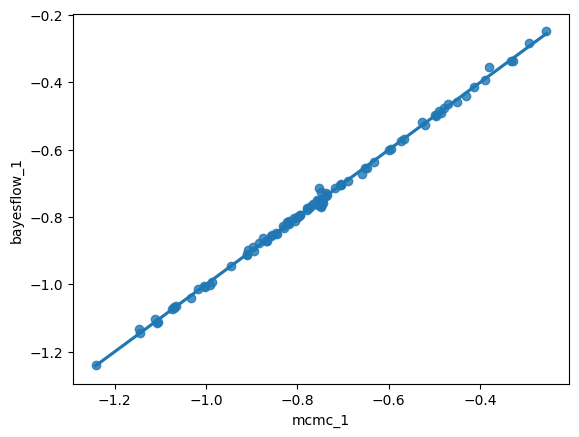

In [17]:
# just a check whether the above function does the right thing
data = pd.DataFrame(data={
    "true_1": true_params[:, 0],
    "true_2": true_params[:, 1],
    "mcmc_1": mcmc_means[:, 0],
    "mcmc_2": mcmc_means[:, 1],
    "bayesflow_1": bayesflow_means[:, 0],
    "bayesflow_2": bayesflow_means[:, 1],
})

sns.regplot(x="mcmc_1", y="bayesflow_1", data=data);

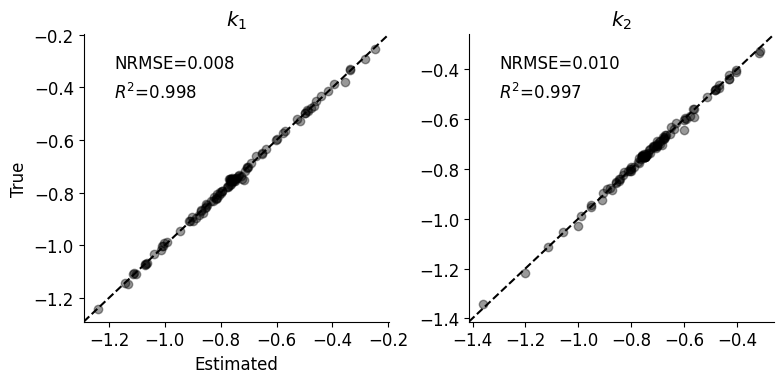

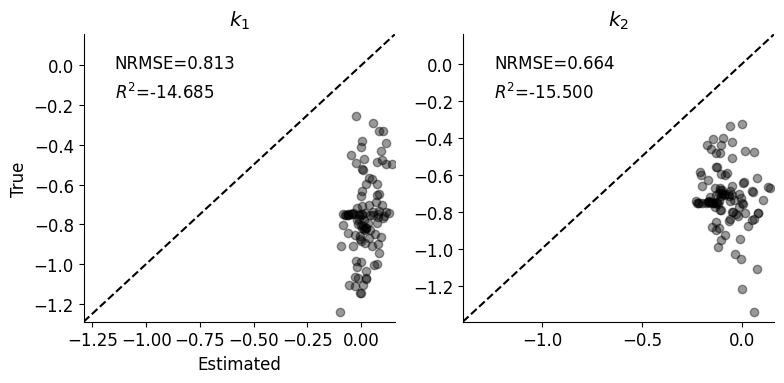

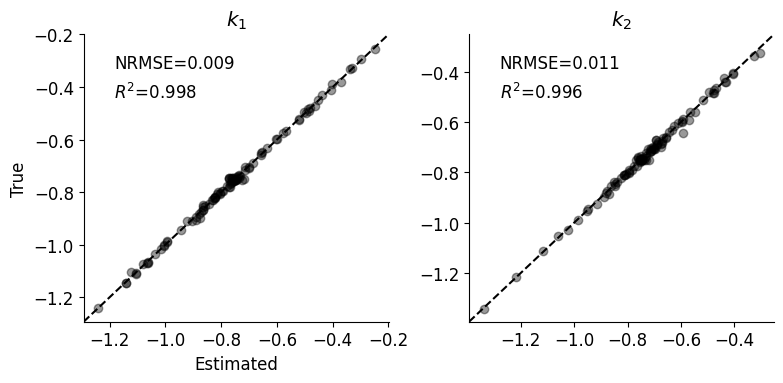

In [18]:
for samples, label in [
    (param_samples_augment01, "Augment 0/1"),
    (param_samples_insert, "Insert -1"),
    (param_samples_timepoints, "Timepoints")
]:
    bayesflow_means = np.mean(samples, axis=1)
    f = true_vs_estimated(mcmc_means, bayesflow_means, ["$k_1$", "$k_2$"])
    f.suptitle(label)

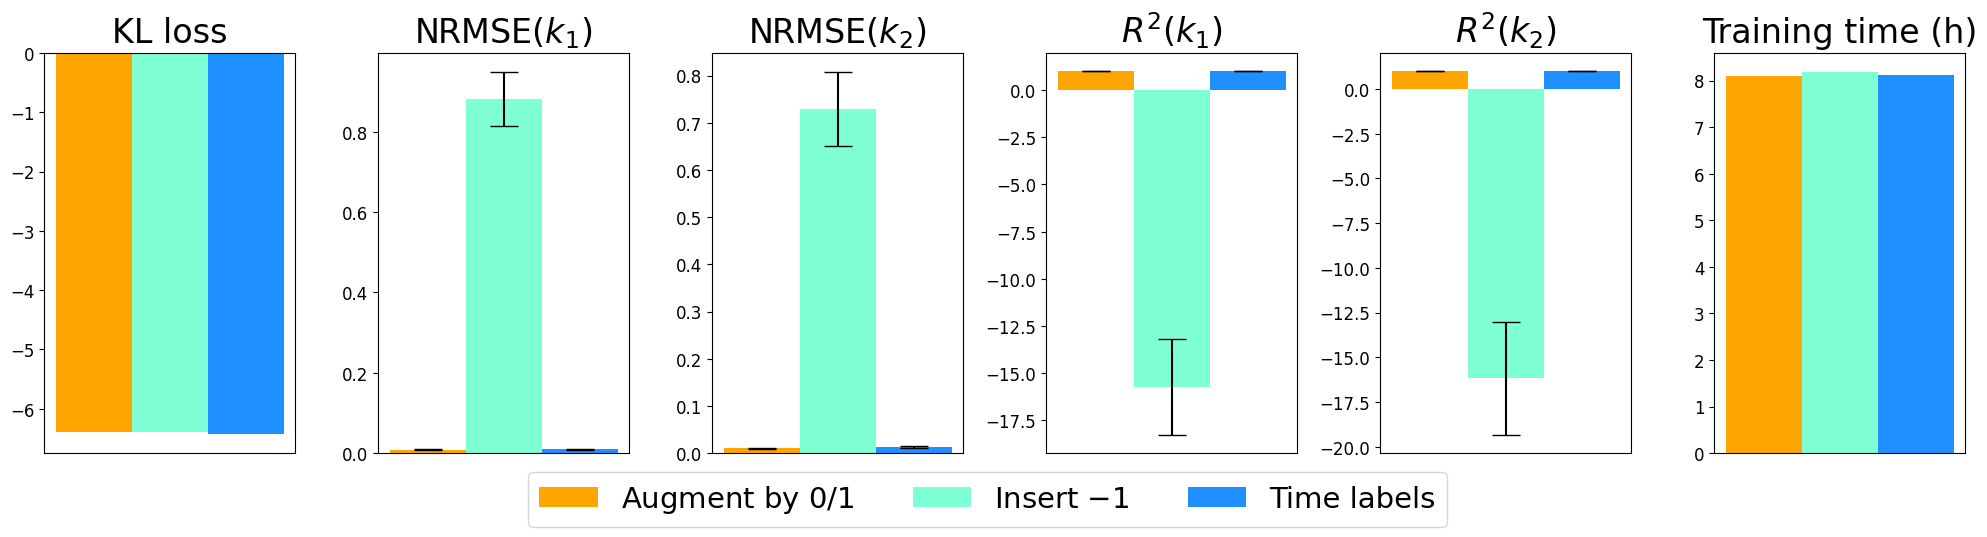

In [19]:
fig, ax = plt.subplots(1, 6, figsize=(20, 5))
plt.rcParams['font.size'] = 15

bar_chart(
    ax, np.array([-6.401, -6.391, -6.429]), 0, 'KL loss',
    #y_lim=np.array([-6.45, -6.35]),
)
bar_chart(
    ax, np.array([a1[0,0], a2[0,0], a3[0,0]]), 1, 'NRMSE$(k_1)$', 
    se=np.array([a1[1,0], a2[1,0], a3[1,0]]),
    #y_lim=np.array([0.0155, 0.029]),
)
bar_chart(
    ax, np.array([a1[0,1], a2[0,1], a3[0,1]]), 2, 'NRMSE$(k_2)$', 
    se=np.array([a1[1,1], a2[1,1], a3[1,1]]),
    #y_lim=np.array([0.030, 0.055]),
)
bar_chart(
    ax, np.array([a1[0,2], a2[0,2], a3[0,2]]), 3, '$R^2(k_1)$', 
    se=np.array([a1[1,2], a2[1,2], a3[1,2]]), 
    #y_lim=np.array([0.963, 0.984]), y_ticks=np.array([0.965, 0.970, 0.975, 0.980]),
)
bar_chart(
    ax, np.array([a1[0,3], a2[0,3], a3[0,3]]), 4, '$R^2(k_2)$', 
    se=np.array([a1[1,3], a2[1,3], a3[1,3]]), 
    #y_lim=np.array([0.895, 0.94]), y_ticks=np.array([0.90, 0.91, 0.92, 0.93, 0.94]),
)
bar_chart(
    ax, np.array([8+6/60, 8+11/60, 8+7/60]), 5, 'Training time (h)', 
    #y_lim=np.array([6.5,8.75]), y_ticks=np.array([6.5, 7.0, 7.5, 8.0, 8.5]),
)

for axes in ax: 
    handles, labels = axes.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5,-0.11), ncol=4, fontsize=21)
plt.tight_layout()
plt.show()
#fig.savefig("figures/{}_bar_chart.png".format('CR3'), dpi=300, bbox_inches='tight')